In [1]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import re
import textwrap
from PIL import Image

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# other
%matplotlib inline
import cmocean.cm as cmo

# import personal modules
# Path to modules
sys.path.append('../modules')
from cw3e_tools import landfall_tool_contour, landfall_tool_vector
import cw3ecmaps as cw3e

# pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# # Set up paths
path_to_data = '/data/downloaded/SCRATCH/cw3eit_scratch/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
# fname = '/data/downloaded/SCRATCH/cw3eit_scratch/GEFS/FullFiles/IVT_Full_2023063006.nc'
# ds = xr.open_dataset(fname)
# ds

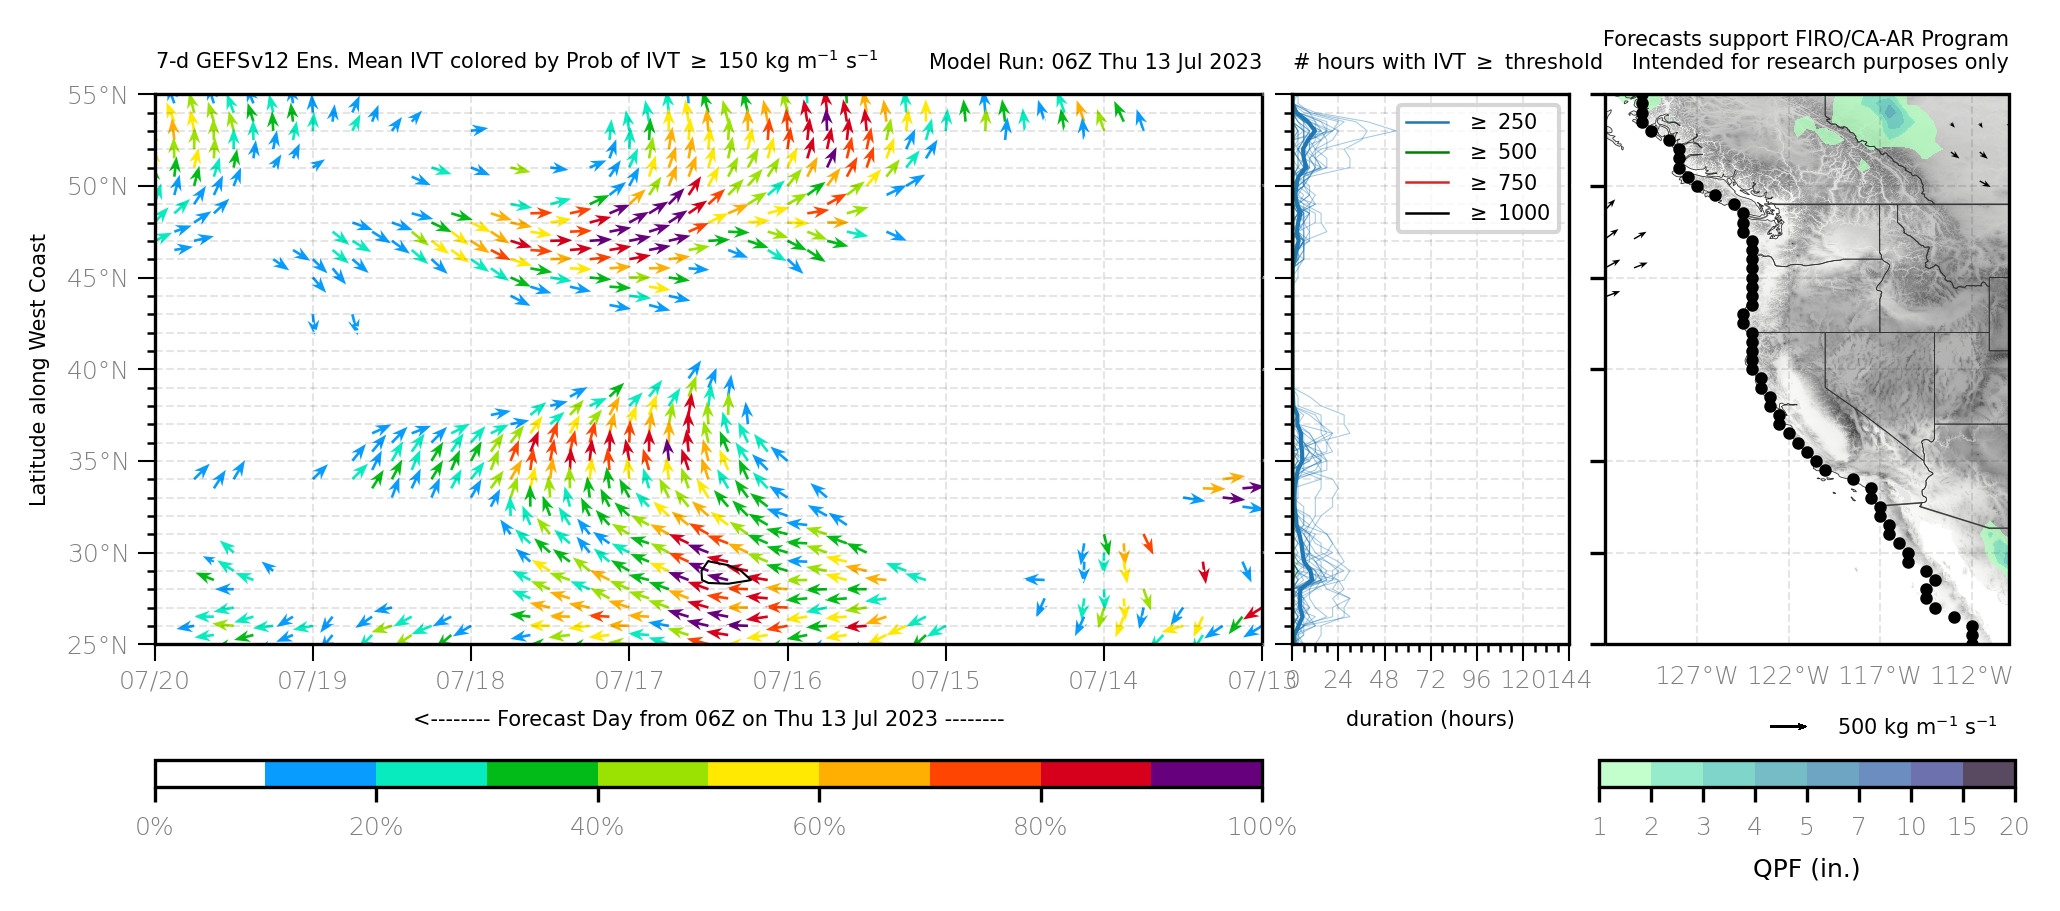

CPU times: user 55.7 s, sys: 1min 17s, total: 2min 12s
Wall time: 2min 54s


In [6]:
%%time
threshold_lst = [150, 250, 500, 750]
textpts_loc_lst = ['coast', 'foothills', 'inland']

for i, threshold in enumerate(threshold_lst[:1]):
    for j, textpts_loc in enumerate(textpts_loc_lst[:1]):
        s = landfall_tool_vector(loc='US-west', ptloc=textpts_loc, forecast='GEFS', threshold=threshold, orientation='latitude')
        s.create_figure()
        # ds = s.load_dataset()

In [5]:
%%time
# date = '20230711' # today's date
# hr = '06' # time start
# url = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs{0}/gfs_0p25_{1}z'.format(date, hr)
# ds = xr.open_dataset(url, decode_times=True)
# ds = ds.isel(time=7*8) # select day 7
# prec = ds['apcpsfc'].sum('time')/25.4 # convert from mm to in
# prec

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-130., -110., 25., 55.])
# cmap, norm, bnds = cw3e.cmap('brian_qpf')
# prec.plot.contourf(ax=ax, cmap=cmap, levels=bnds, norm=norm, extend='max', transform=ccrs.PlateCarree())
# ax.coastlines()

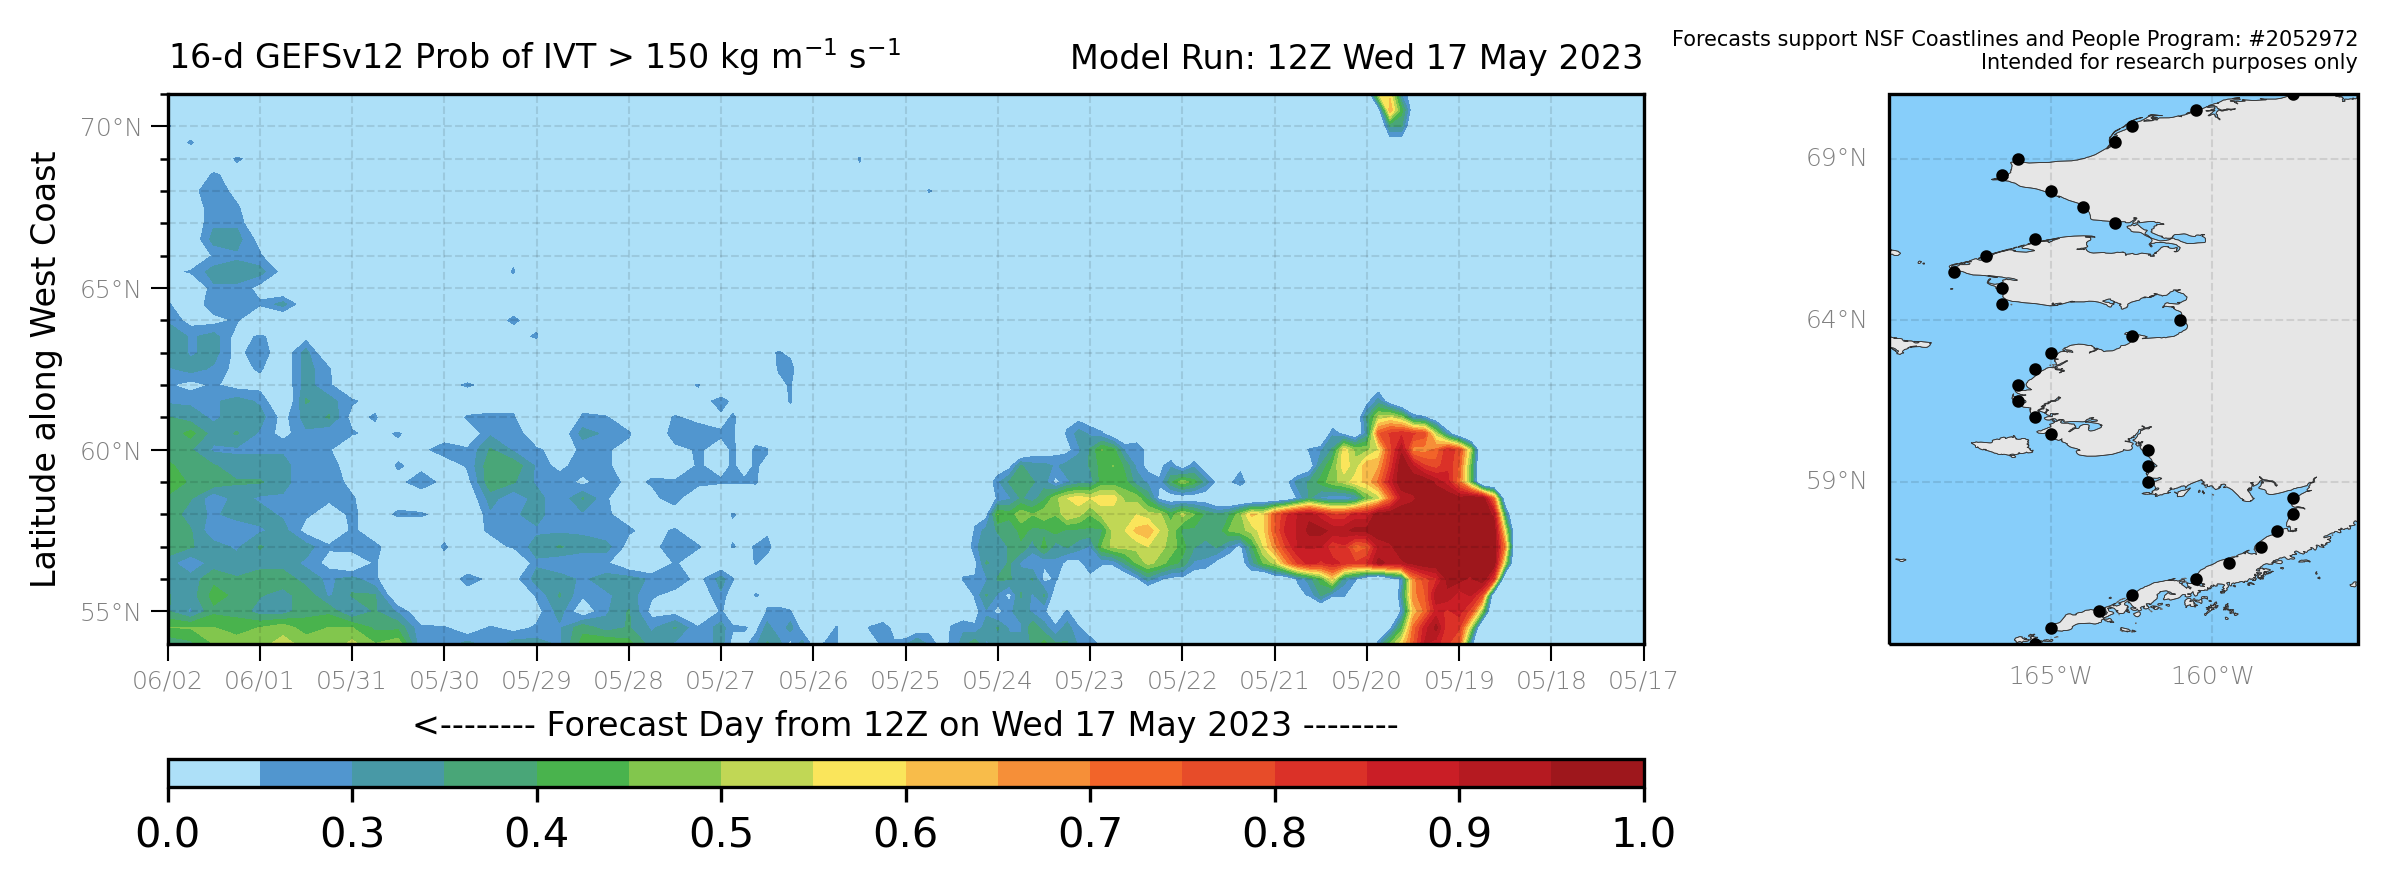

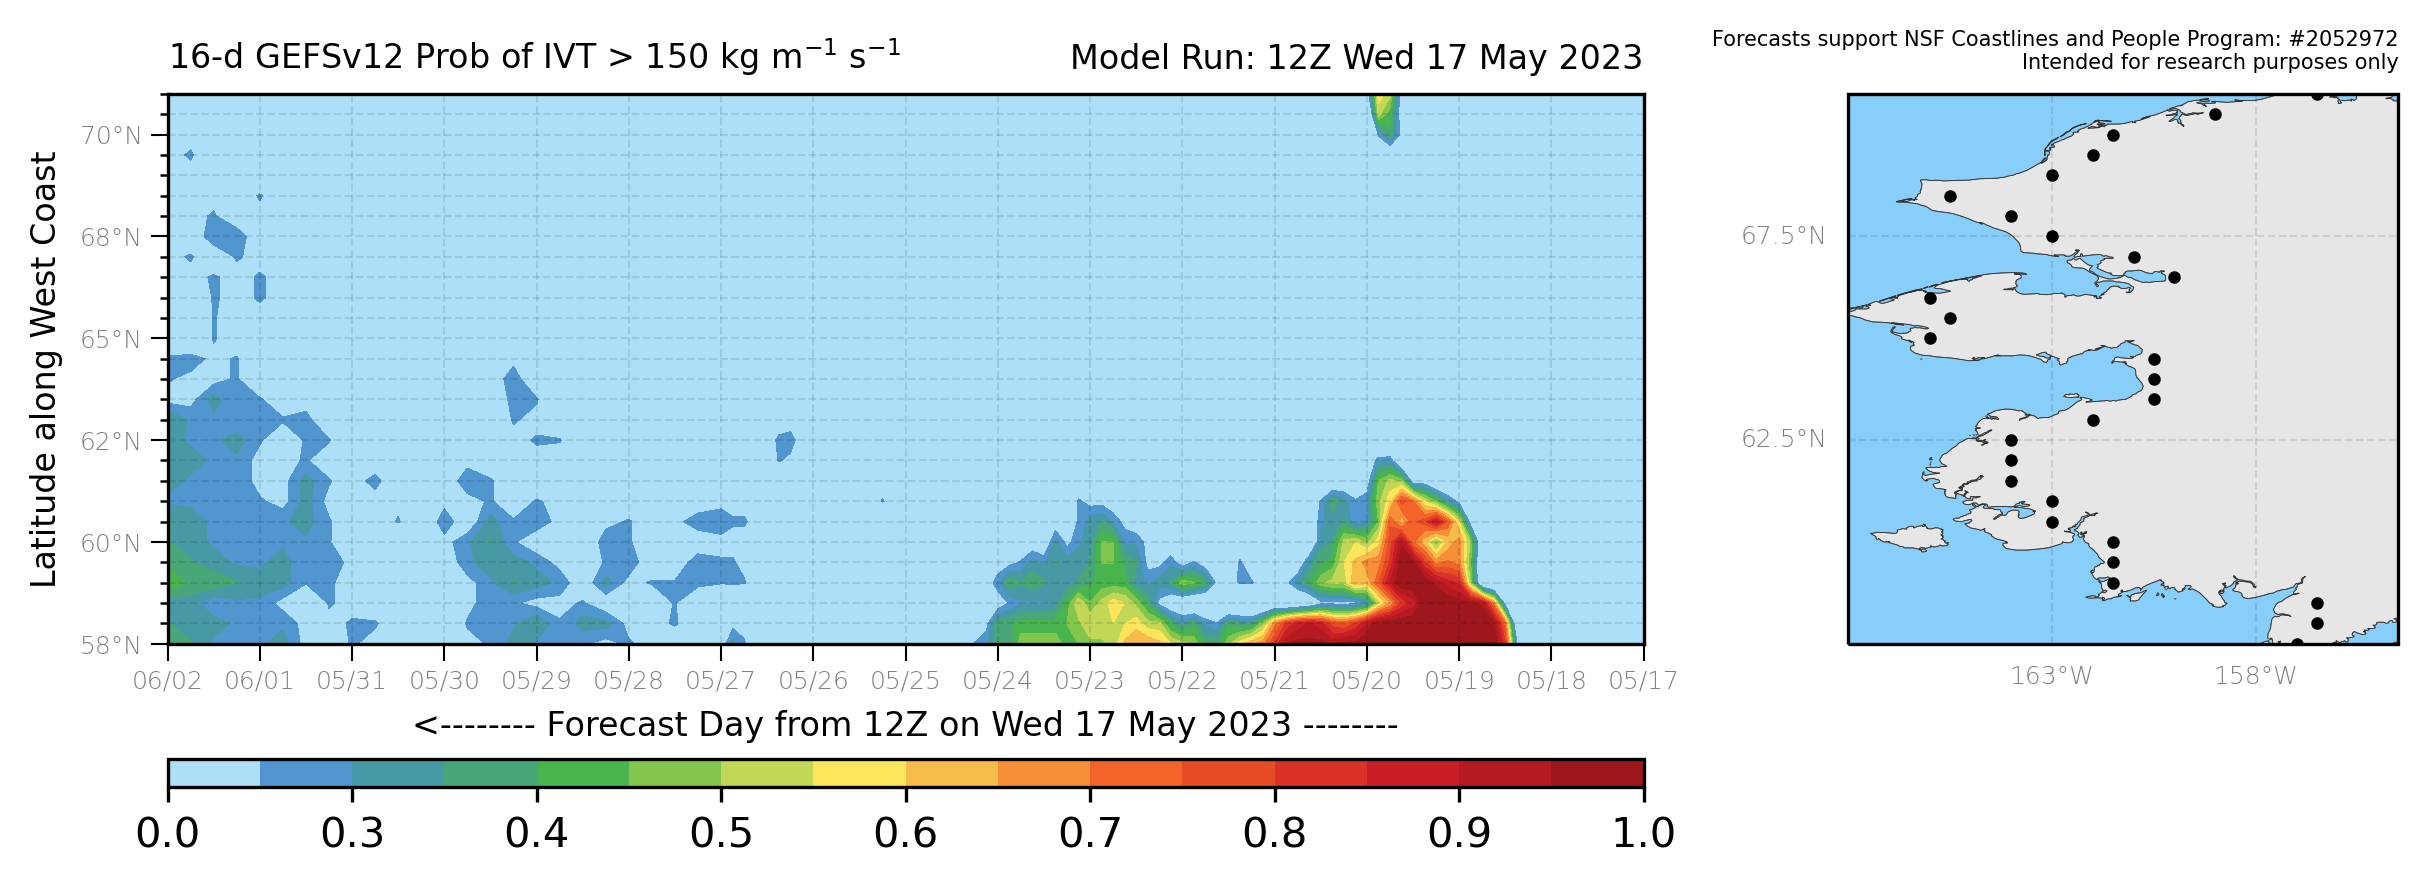

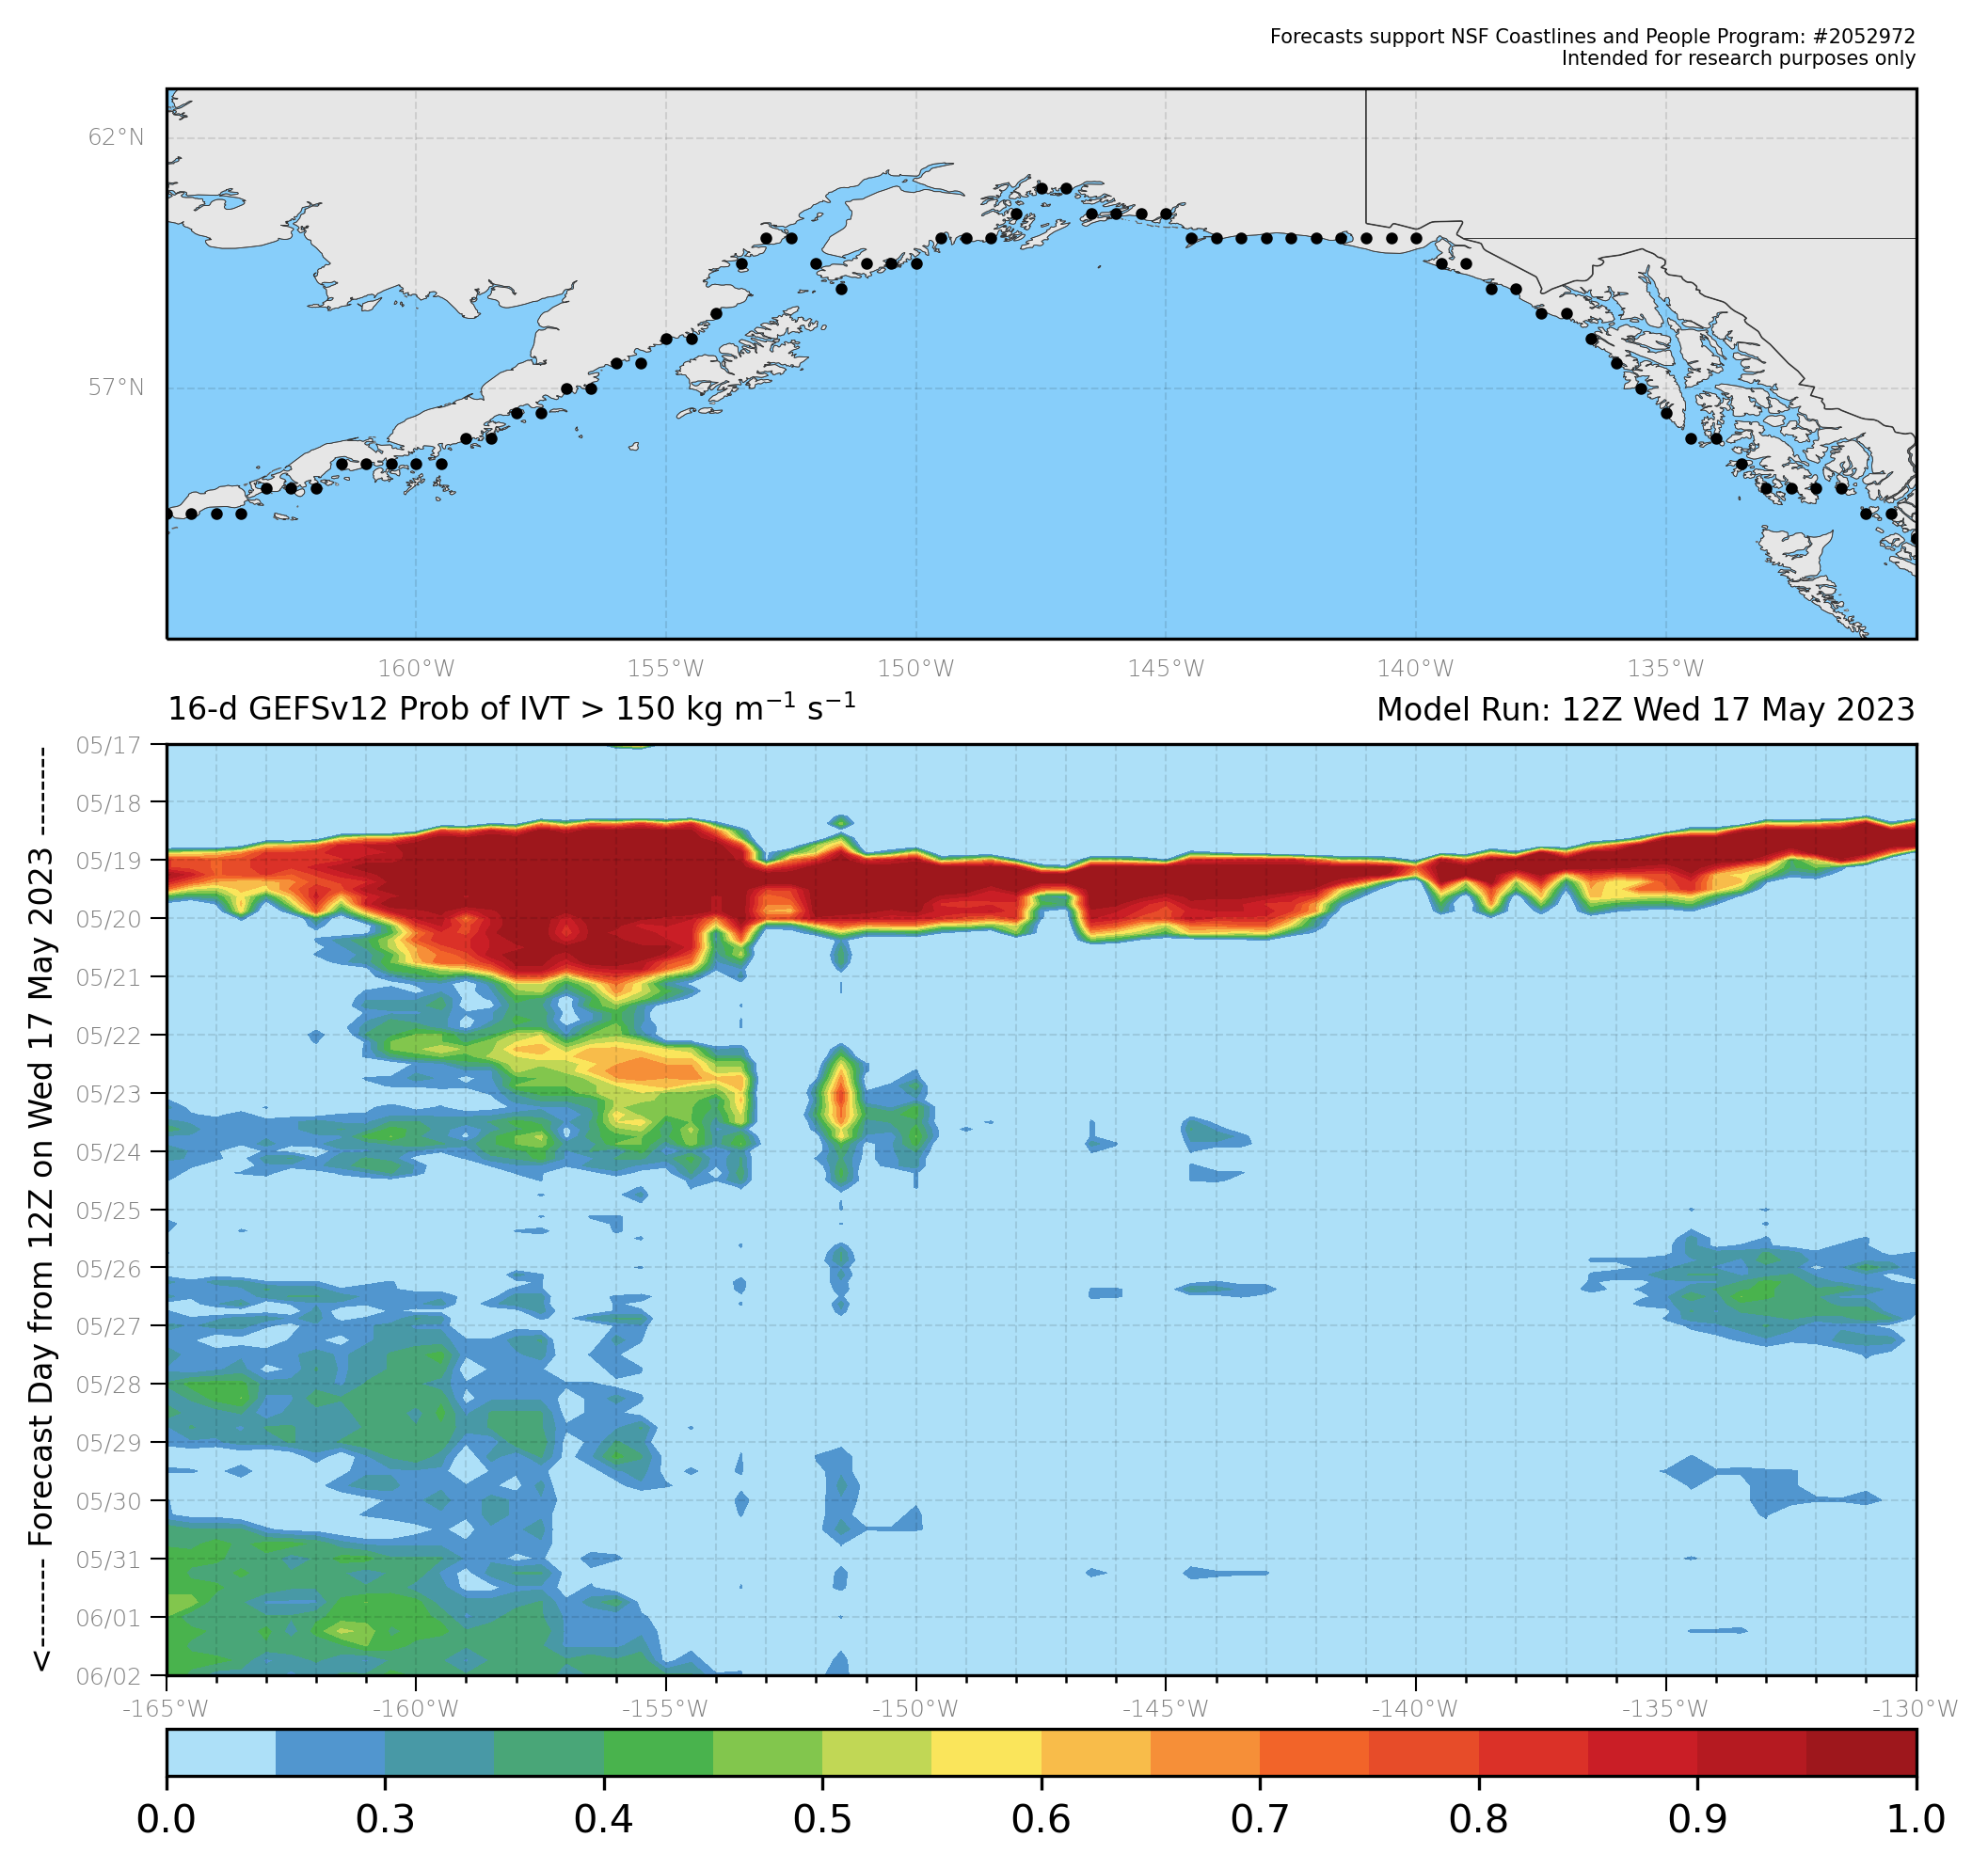

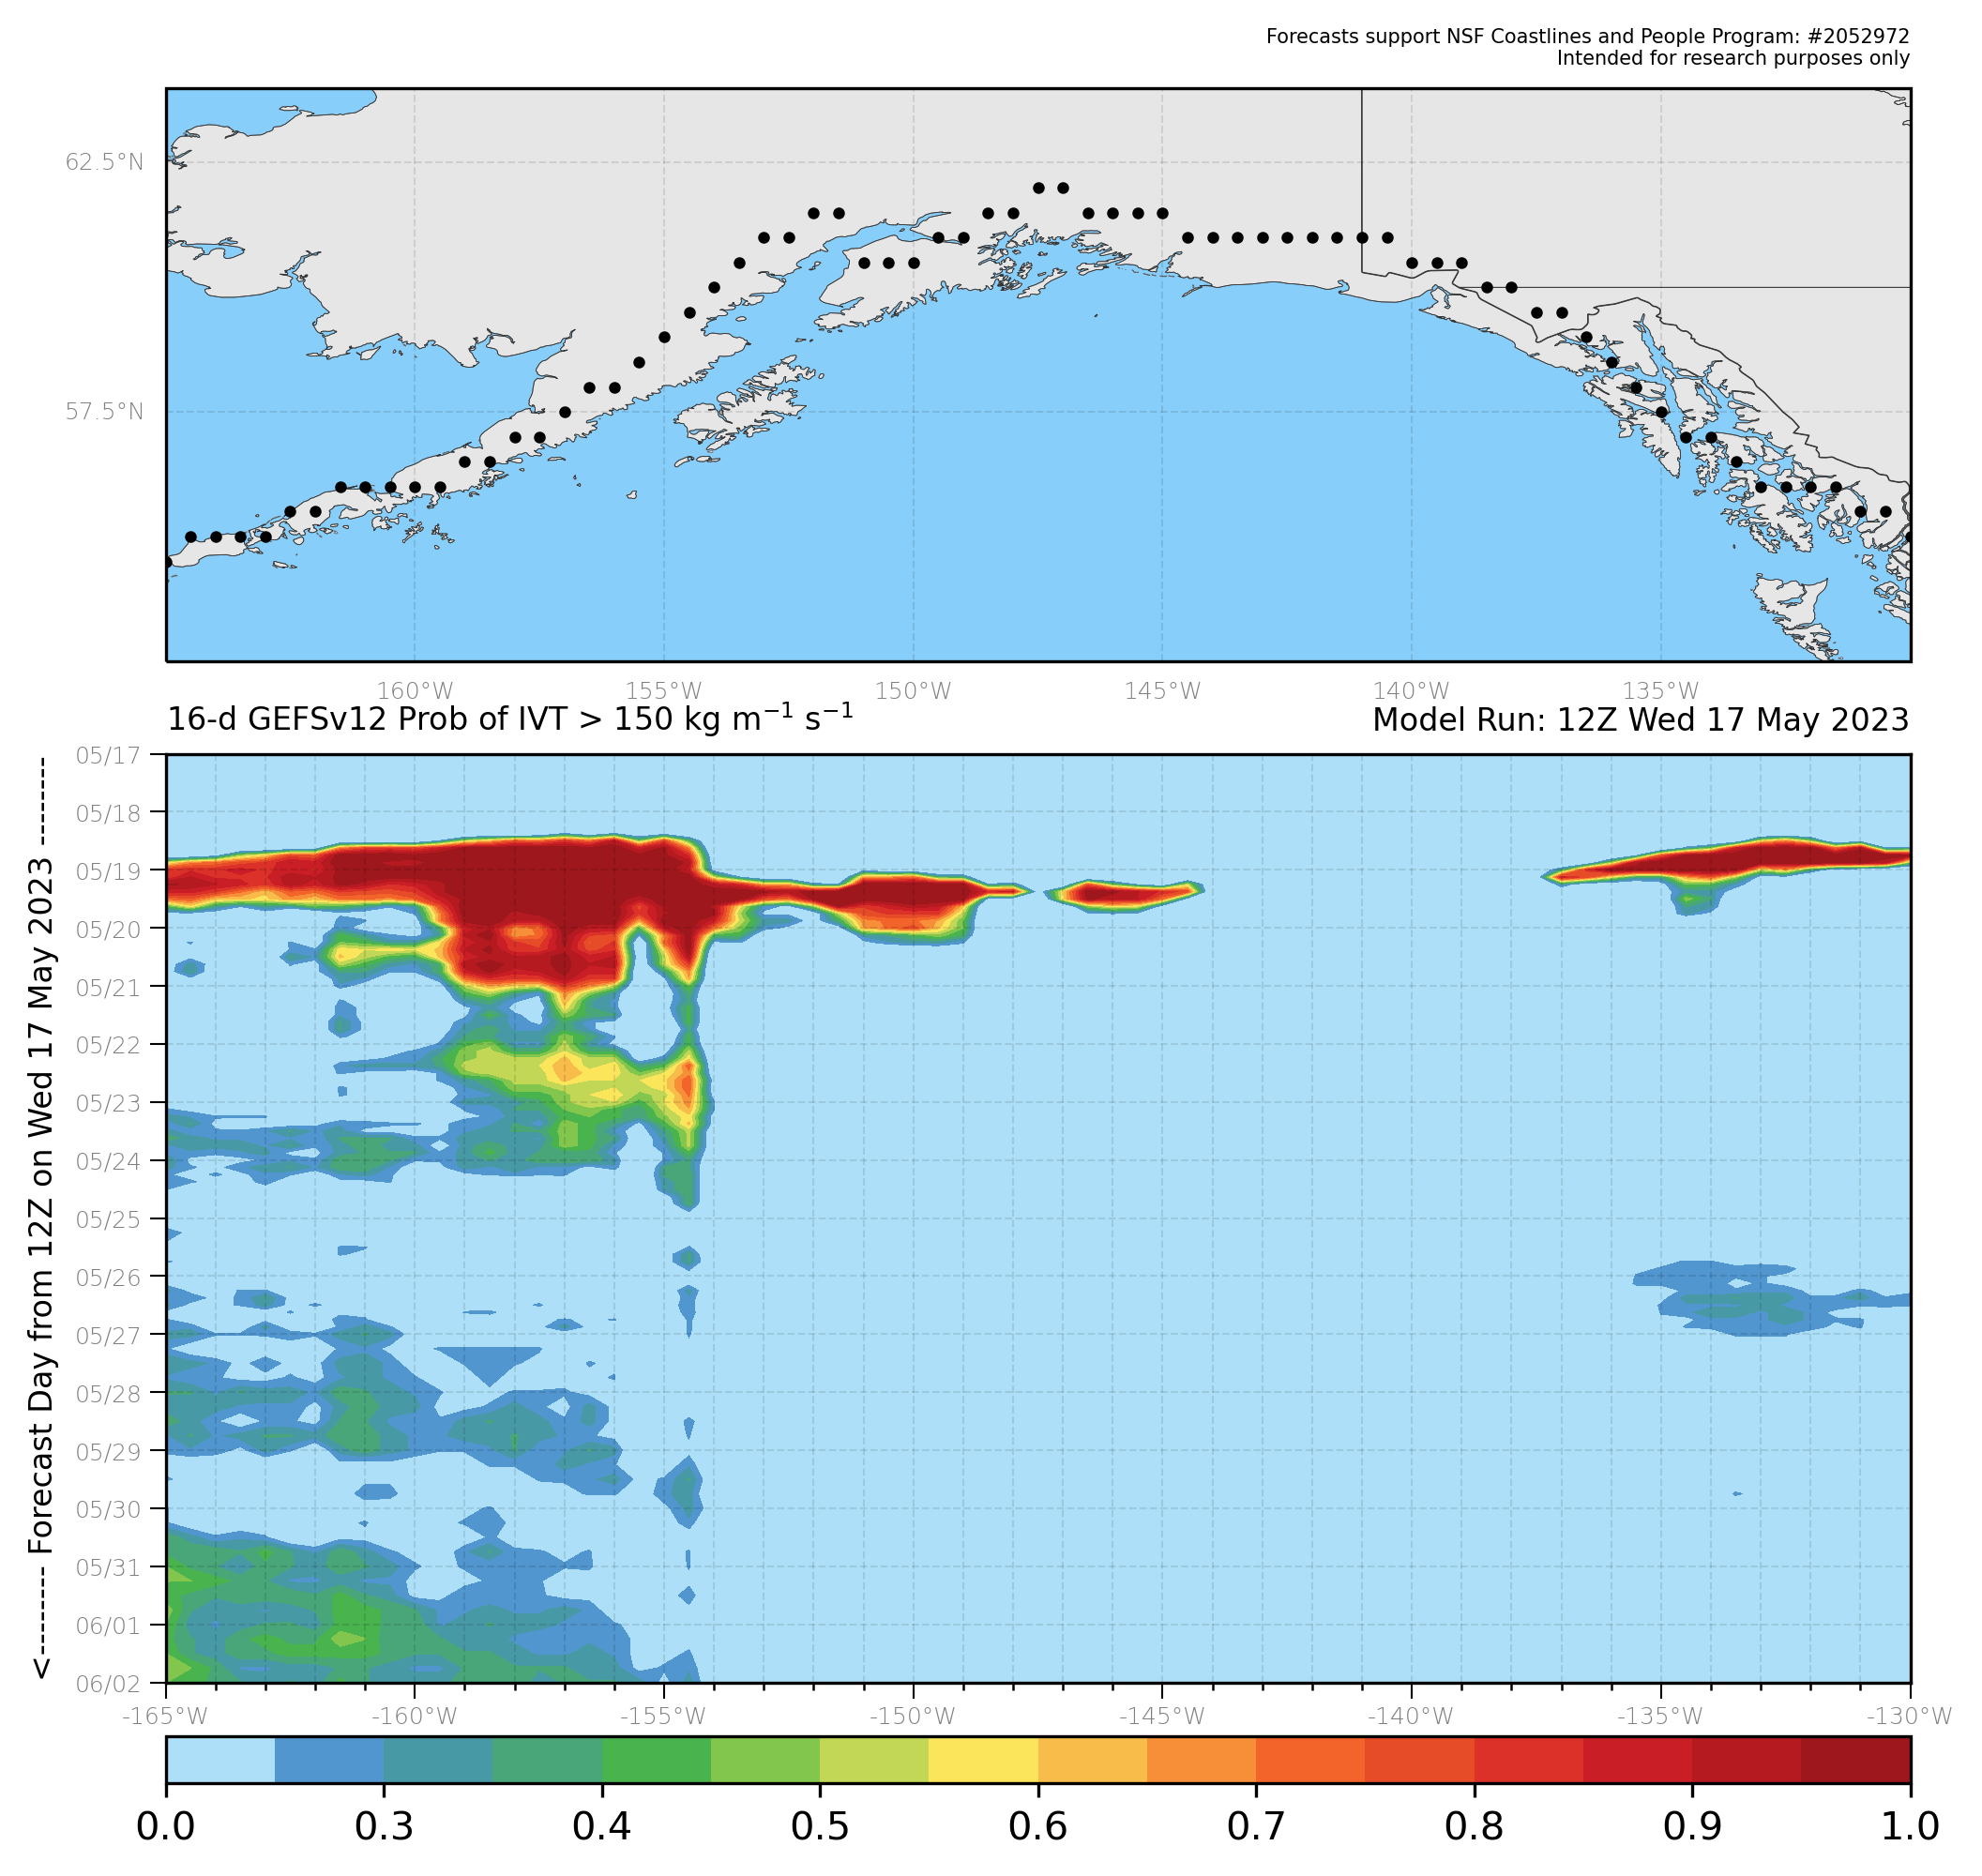

In [7]:
ptloc_lst = ['coast', 'inland']*2
loc_lst = ['AK']*2 + ['SAK']*2
ori_lst = ['latitude']*2 + ['longitude']*2

for i, (ptloc, loc, ori) in enumerate(zip(ptloc_lst, loc_lst, ori_lst)):
    s = landfall_tool_contour(loc=loc, ptloc=ptloc, forecast='GEFS', threshold=150, orientation=ori)
    s.create_figure()